### Phase 1 : Collecte de données
* on a interrogé l’API de Wikimedia Commons pour récupérer au moins 100 images de la catégorie "Category:Eiffel Tower" , télécharger les images et en extrait des métadonnées (dimensions, format, orientation, EXIF, etc.) pour les enregistrer dans un fichier JSON.


In [38]:
import os
import requests
import json
import time
from PIL import Image, ExifTags
from PIL.TiffImagePlugin import IFDRational
from io import BytesIO

# --- Configuration ---
USER_AGENT = "RecommenderImages/1.0 (rhoumahejer20@gmail.com)"  # Remplacez avec vos informations
HEADERS = {"User-Agent": USER_AGENT}
COMMONS_API_URL = "https://commons.wikimedia.org/w/api.php"

# Thème choisi :
theme_category = "Category:Eiffel Tower"
nombre_images = 100  # Nombre minimum d'images à récupérer

# --- 1. Création du dossier "images" ---
os.makedirs("images", exist_ok=True)

# --- 2. Récupération de la liste d'images pour le thème spécifié ---
print(f"Récupération de la liste d'images pour le thème: {theme_category}...")

members = []
params_category = {
    "action": "query",
    "list": "categorymembers",
    "cmtitle": theme_category,
    "cmtype": "file",
    "cmlimit": "max",  # maximum autorisé par requête
    "format": "json"
}

while True:
    response_category = requests.get(COMMONS_API_URL, params=params_category, headers=HEADERS)
    if response_category.status_code != 200:
        print("Erreur lors de la récupération de la liste d'images. Code d'erreur :", response_category.status_code)
        exit(1)
    try:
        data_category = response_category.json()
    except Exception as e:
        print("Erreur lors du décodage JSON de la réponse de la liste d'images :", e)
        print("Contenu de la réponse :", response_category.text)
        exit(1)
    
    batch_members = data_category.get("query", {}).get("categorymembers", [])
    members.extend(batch_members)
    
    # Si un token de continuation est présent, on le récupère pour la prochaine requête.
    if "continue" in data_category:
        params_category["cmcontinue"] = data_category["continue"]["cmcontinue"]
    else:
        break  # Plus de résultats
    
    # Arrêter dès que le nombre minimum d'images est atteint.
    if len(members) >= nombre_images:
        break

if len(members) < nombre_images:
    print(f"Attention : La catégorie '{theme_category}' ne contient que {len(members)} images.")
else:
    print(f"{len(members)} images récupérées.")

# On ne garde que les premiers 'nombre_images'
members = members[:nombre_images]

# Extraction des titres (par exemple, "File:Example.jpg")
titles = [member["title"] for member in members]

# --- 3. Récupération des informations détaillées pour chaque image par lots ---
def chunks(lst, n):
    """Divise une liste en morceaux de taille n."""
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

imageinfo_results = {}
batch_size = 50  # Traitement par lots pour éviter des URL trop longues

for batch in chunks(titles, batch_size):
    params_imageinfo = {
        "action": "query",
        "titles": "|".join(batch),
        "prop": "imageinfo",
        "iiprop": "url|size|mime",
        "format": "json"
    }
    response_imageinfo = requests.get(COMMONS_API_URL, params=params_imageinfo, headers=HEADERS)
    if response_imageinfo.status_code != 200:
        print("Erreur lors de la récupération des informations d'image pour le lot :", batch)
        continue
    try:
        data_batch = response_imageinfo.json()
    except Exception as e:
        print("Erreur lors du décodage JSON pour le lot :", batch)
        print("Erreur :", e)
        print("Contenu de la réponse :", response_imageinfo.text)
        continue

    pages = data_batch.get("query", {}).get("pages", {})
    imageinfo_results.update(pages)
    time.sleep(1)  # Pause pour ne pas saturer l'API

if not imageinfo_results:
    print("Aucune information d'image récupérée.")
    exit(1)

# --- 4. Téléchargement des images et extraction des métadonnées ---
metadata_list = []
count = 0

print("Téléchargement et traitement des images...")

for page_id, page_data in imageinfo_results.items():
    imageinfo = page_data.get("imageinfo", [])
    if not imageinfo:
        continue
    info = imageinfo[0]
    image_url = info.get("url")
    mime_type = info.get("mime", "")

    # Ignorer les images vectorielles (SVG)
    if mime_type == "image/svg+xml":
        print(f"Image {image_url} est au format SVG, sautée.")
        continue

    try:
        response_image = requests.get(image_url, headers=HEADERS)
        if response_image.status_code != 200:
            print(f"Erreur lors du téléchargement de l'image {image_url}")
            continue

        image_data = response_image.content
        image = Image.open(BytesIO(image_data))
        width, height = image.size
        format_image = image.format

        # Déterminer l'orientation
        if width > height:
            orientation = "paysage"
        elif width < height:
            orientation = "portrait"
        else:
            orientation = "carré"

        # Extraction des données EXIF (si disponibles)
        exif_data = {}
        if hasattr(image, "_getexif"):
            raw_exif = image._getexif()
            if raw_exif:
                for tag, value in raw_exif.items():
                    decoded = ExifTags.TAGS.get(tag, tag)
                    exif_data[decoded] = value

        # Construction du nom de fichier à partir de l'URL
        extension = image_url.split('.')[-1].split('?')[0]
        count += 1
        filename = f"images/image_{count}.{extension}"

        # Sauvegarder l'image sur le disque
        with open(filename, "wb") as f:
            f.write(image_data)

        # Construction du dictionnaire de métadonnées
        meta = {
            "nom_fichier": filename,
            "url_source": image_url,
            "taille": {"largeur": width, "hauteur": height},
            "format": format_image,
            "orientation": orientation,
            "mime": mime_type,
            "exif": exif_data
        }
        if "DateTimeOriginal" in exif_data:
            meta["date_creation"] = exif_data["DateTimeOriginal"]
        if "Model" in exif_data:
            meta["modele_appareil"] = exif_data["Model"]

        metadata_list.append(meta)
        print(f"Image {filename} téléchargée et traitée.")

    except Exception as e:
        print(f"Erreur lors du traitement de l'image {image_url}: {e}")

# --- 5. Sauvegarde des métadonnées dans un fichier JSON ---
def default_converter(o):
    if isinstance(o, IFDRational):
        try:
            return float(o)
        except ZeroDivisionError:
            return 0.0  # Ou renvoyer None selon vos besoins
    if isinstance(o, bytes):
        try:
            return o.decode("utf-8")
        except Exception:
            return str(o)
    raise TypeError(f"Object of type {o.__class__.__name__} is not JSON serializable")

with open("metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata_list, f, ensure_ascii=False, indent=4, default=default_converter)

print("Téléchargement et extraction des métadonnées terminés.")


Récupération de la liste d'images pour le thème: Category:Eiffel Tower...
393 images récupérées.
Téléchargement et traitement des images...
Image images/image_1.jpg téléchargée et traitée.
Image images/image_2.gif téléchargée et traitée.
Image images/image_3.jpg téléchargée et traitée.
Image images/image_4.jpg téléchargée et traitée.
Image images/image_5.jpg téléchargée et traitée.
Image images/image_6.tif téléchargée et traitée.
Erreur lors du traitement de l'image https://upload.wikimedia.org/wikipedia/commons/8/81/Collectif_-_Protestation_des_artistes_contre_la_tour_de_M._Eiffel%2C_paru_dans_Le_Temps%2C_14_f%C3%A9vrier_1887.djvu: cannot identify image file <_io.BytesIO object at 0x000001F8E4CEAE80>
Image images/image_7.jpeg téléchargée et traitée.
Image images/image_8.jpg téléchargée et traitée.
Image images/image_9.jpg téléchargée et traitée.
Image images/image_10.jpg téléchargée et traitée.
Image images/image_11.jpg téléchargée et traitée.
Image images/image_12.jpg téléchargée et 

### Phase 2 :Étiquetage et annotation 


In [ ]:
import os
import json
# os et json : Permettent de gérer le système de fichiers 
import numpy as np
from PIL import Image #PIL (Python Imaging Library) : Permet de charger et manipuler des images.
from sklearn.cluster import KMeans KMeans de sklearn.cluster : Implémente l’algorithme de clustering K-means, 
#qui sera utilisé pour extraire les couleurs dominantes d’une image.

# Charger les métadonnées précédemment extraites
with open("metadata.json", "r", encoding="utf-8") as f:
    metadata_list = json.load(f)

def get_dominant_colors(image_path, k=3):
    """Analyse les couleurs dominantes d'une image en utilisant K-means."""
    image = Image.open(image_path)
    image = image.resize((150, 150))  # Redimensionner pour accélérer le traitement
    pixels = np.array(image).reshape(-1, 3)
    
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(pixels)
    
    colors = kmeans.cluster_centers_.astype(int)
    return ["#{:02x}{:02x}{:02x}".format(*color) for color in colors]

def generate_tags(metadata):
    """Génère des tags basés sur les métadonnées."""
    tags = set()
    
    # Ajouter des tags liés à l'orientation
    tags.add(metadata["orientation"])
    
    # Ajouter des tags liés à l'appareil photo
    if "modele_appareil" in metadata:
        tags.add(metadata["modele_appareil"].replace(" ", "_"))
    
    # Ajouter des tags liés à la taille
    if metadata["taille"]["largeur"] > 3000:
        tags.add("haute_resolution")
    
    return list(tags)

# Annoter chaque image
annotated_data = []
for metadata in metadata_list:
    image_path = metadata["nom_fichier"]
    
    if not os.path.exists(image_path):
        print(f"Image non trouvée: {image_path}")
        continue
    
    metadata["couleurs_dominantes"] = get_dominant_colors(image_path)
    metadata["tags"] = generate_tags(metadata)
    annotated_data.append(metadata)

# Sauvegarde des annotations
with open("annotations.json", "w", encoding="utf-8") as f:
    json.dump(annotated_data, f, ensure_ascii=False, indent=4)

print("Annotation terminée et enregistrée dans annotations.json")


## Phase 3 : Analyses de données 
* Création d'utilisateurs aléatoires :
* création 5 utilisateurs . Pour chacun, 10 images sont sélectionnées aléatoirement depuis le fichier annotations.json
* Construction du profil utilisateur :
Pour chaque utilisateur, le script agrège les données de ses images sélectionnées afin de déterminer :
    * Couleur préférée : la couleur dominante la plus fréquente parmi les images sélectionnées.
    * Orientation préférée : le mode parmi les orientations (ex. : paysage, portrait ou carré).
    * Taille d’image préférée : en fonction de la largeur, l’image est catégorisée en « thumbnail », « medium » ou « large ».
    * Balises favorites : les trois tags les plus fréquents.
    * Résolution moyenne : calculée à partir des largeurs et hauteurs des images.
    * Analyse par clustering :
        * Pour regrouper les utilisateurs selon leurs préférences, nous transformons les attributs en valeurs numériques et construisons un vecteur pour chaque profil. Ensuite, l’algorithme K-means (ici avec 2 clusters) regroupe les profils similaires. Le numéro du cluster est ajouté au profil, ce qui permet ensuite de proposer des recommandations en fonction du groupe auquel appartient un utilisateur.

In [ ]:
# importation des bibliothéques : 
import os
import json
import random
import numpy as np
from collections import Counter
from sklearn.cluster import KMeans

# 1. Chargement des annotations issues de la phase précédente
with open("annotations.json", "r", encoding="utf-8") as f:
    annotations = json.load(f)

# 2. Fonctions utilitaires

def get_size_category(width):
    """
    Retourne une catégorie de taille en fonction de la largeur.
    Par exemple :
        - thumbnail : largeur < 500 pixels
        - medium    : 500 <= largeur < 1500 pixels
        - large     : largeur >= 1500 pixels
    """
    if width < 500:
        return "thumbnail"
    elif width < 1500:
        return "medium"
    else:
        return "large"

def hex_to_rgb(hex_color):
    """
    Convertit une couleur au format hexadécimal en tuple de valeurs RGB.
    Exemple : \"#ff5733\" -> (255, 87, 51)
    """
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))


# 3. Simulation de la sélection d'images par des utilisateurs aléatoires

NUM_USERS = 5                # Par exemple, nous créons 5 utilisateurs
NUM_IMAGES_PER_USER = 10     # Chaque utilisateur sélectionnera 10 images (si disponibles)

user_profiles = []

for user_id in range(1, NUM_USERS + 1):
    # Pour chaque utilisateur, sélection aléatoire d'images issues de la base d'annotations
    selected_images = random.sample(annotations, min(NUM_IMAGES_PER_USER, len(annotations)))
    
    # Listes pour accumuler les préférences issues des images sélectionnées
    orientations = []
    sizes = []
    colors = []       # On prendra ici la première couleur dominante de chaque image
    tags_all = []
    widths = []
    heights = []
    
    for image in selected_images:
        # Récupération de l'orientation
        orientation = image.get("orientation")
        if orientation:
            orientations.append(orientation)
        
        # Récupération de la taille (largeur et hauteur)
        taille = image.get("taille", {})
        width = taille.get("largeur")
        height = taille.get("hauteur")
        if width is not None:
            sizes.append(get_size_category(width))
            widths.append(width)
        if height is not None:
            heights.append(height)
        
        # Récupération des couleurs dominantes (on prend la première couleur, par simplicité)
        dominant_colors = image.get("couleurs_dominantes", [])
        if dominant_colors:
            colors.append(dominant_colors[0])
        
        # Récupération des tags
        image_tags = image.get("tags", [])
        tags_all.extend(image_tags)
    
    # Calcul des préférences agrégées par utilisateur
    preferred_orientation = Counter(orientations).most_common(1)[0][0] if orientations else None
    preferred_size = Counter(sizes).most_common(1)[0][0] if sizes else None
    preferred_color = Counter(colors).most_common(1)[0][0] if colors else None
    favorite_tags = [tag for tag, count in Counter(tags_all).most_common(3)] if tags_all else []
    avg_width = int(sum(widths) / len(widths)) if widths else 0
    avg_height = int(sum(heights) / len(heights)) if heights else 0
    
    user_profile = {
        "user_id": user_id,
        "selected_images": [img.get("nom_fichier") for img in selected_images],
        "preferred_orientation": preferred_orientation,
        "preferred_size_category": preferred_size,
        "preferred_color": preferred_color,
        "favorite_tags": favorite_tags,
        "average_resolution": {"width": avg_width, "height": avg_height}
    }
    user_profiles.append(user_profile)

# Sauvegarde des profils utilisateurs dans un fichier JSON
with open("user_profiles.json", "w", encoding="utf-8") as f:
    json.dump(user_profiles, f, ensure_ascii=False, indent=4)

print("Les profils utilisateurs ont été créés et enregistrés dans 'user_profiles.json'.")


# 4. Analyse des profils utilisateurs par clustering
# Pour appliquer un clustering, nous devons transformer les attributs catégoriels en valeurs numériques.

# Définir des mappings pour l'orientation et la catégorie de taille
orientation_mapping = {"paysage": 0, "portrait": 1, "carré": 2}
size_mapping = {"thumbnail": 0, "medium": 1, "large": 2}

# Construction d'un vecteur de caractéristiques pour chaque profil utilisateur
# On utilisera :
#   - Orientation préférée (numérique)
#   - Catégorie de taille préférée (numérique)
#   - Résolution moyenne (largeur et hauteur)
#   - Couleur préférée (convertie en valeurs RGB)
feature_vectors = []

for profile in user_profiles:
    orient = orientation_mapping.get(profile.get("preferred_orientation"), -1)
    size_cat = size_mapping.get(profile.get("preferred_size_category"), -1)
    avg_width = profile.get("average_resolution", {}).get("width", 0)
    avg_height = profile.get("average_resolution", {}).get("height", 0)
    
    # Conversion de la couleur préférée en valeurs RGB (ou (0, 0, 0) par défaut)
    pref_color = profile.get("preferred_color")
    if pref_color:
        r, g, b = hex_to_rgb(pref_color)
    else:
        r, g, b = (0, 0, 0)
    
    vector = [orient, size_cat, avg_width, avg_height, r, g, b]
    feature_vectors.append(vector)

feature_vectors = np.array(feature_vectors)

# Application de l'algorithme K-means pour regrouper les profils similaires
num_clusters = 2  # Par exemple, nous créons 2 clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(feature_vectors)

# Ajout de l'information de cluster dans chaque profil utilisateur
for i, profile in enumerate(user_profiles):
    profile["cluster"] = int(clusters[i])

# Sauvegarde des profils mis à jour avec l'information de cluster
with open("user_profiles.json", "w", encoding="utf-8") as f:
    json.dump(user_profiles, f, ensure_ascii=False, indent=4)

print(f"Clustering terminé : {num_clusters} clusters identifiés parmi les profils utilisateurs.")


## Phase 4 : Visualisation des données 

#### Importations et fonctions utilitaires


In [6]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Fonction utilitaire pour catégoriser la taille d'une image
def get_size_category(width):
    if width < 500:
        return "thumbnail"
    elif width < 1500:
        return "medium"
    else:
        return "large"

# Conversion d'une couleur hexadécimale en tuple RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

# Extraction de l'année à partir d'une chaîne de date EXIF (format "YYYY:MM:DD HH:MM:SS")
def parse_year(date_str):
    try:
        year = date_str.split(':')[0]
        return int(year)
    except Exception:
        return None


#### Visualisation – Nombre d'images par année

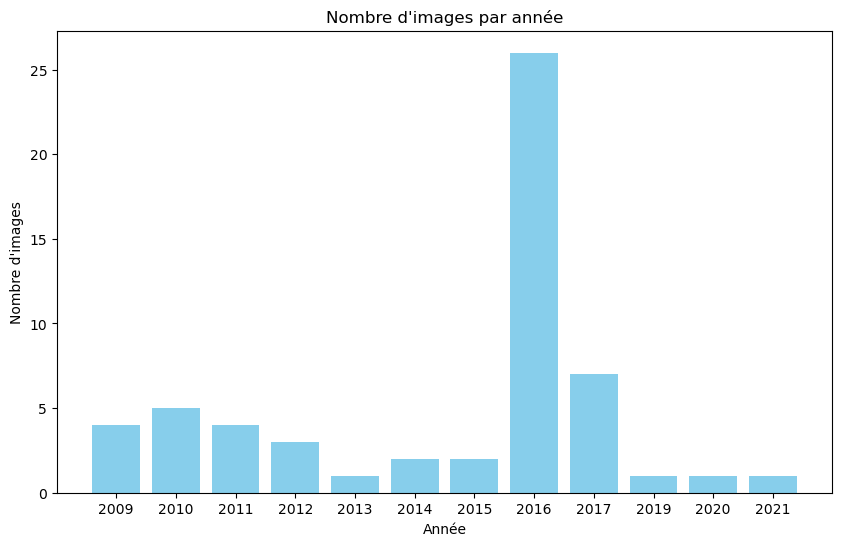

In [9]:
def visualize_images_per_year(annotations):
    years = []
    for ann in annotations:
        date_creation = ann.get("date_creation")
        if date_creation:
            year = parse_year(date_creation)
            if year:
                years.append(year)
    if years:
        year_counts = Counter(years)
        sorted_years = sorted(year_counts.items())
        x = [str(year) for year, count in sorted_years]
        y = [count for year, count in sorted_years]
        plt.figure(figsize=(10, 6))
        plt.bar(x, y, color='skyblue')
        plt.xlabel("Année")
        plt.ylabel("Nombre d'images")
        plt.title("Nombre d'images par année")
        plt.show()
    else:
        print("Aucune information de date n'est disponible pour les images.")

# Charger les annotations (supposées être enregistrées dans "annotations.json")
with open("annotations.json", "r", encoding="utf-8") as f:
    annotations = json.load(f)

visualize_images_per_year(annotations)


##### Interprétation 
* Ce graphique montre le nombre d'images associées à chaque année (extrait de la donnée EXIF "date_creation").
* il y a un pic en 2016 qui  peut indiquer une période où la production ou la disponibilité d'images était plus importante.
* L'absence de données pour certaines années peut aussi être constatée comme en 2019 , 2020 et 2021 qui sont négligeables par rapport les autres années

#### Visualisation – Répartition des images par catégorie de taille

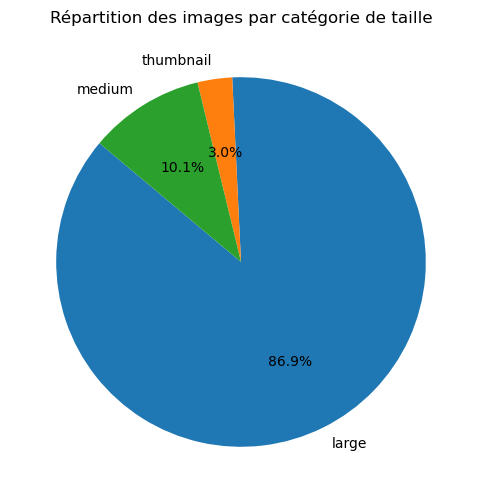

In [21]:
def visualize_size_distribution(annotations):
    sizes = []
    for ann in annotations:
        taille = ann.get("taille", {})
        width = taille.get("largeur")
        if width is not None:
            sizes.append(get_size_category(width))
    size_counts = Counter(sizes)
    labels = list(size_counts.keys())
    counts = list(size_counts.values())
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title("Répartition des images par catégorie de taille")
    plt.show()

visualize_size_distribution(annotations)


##### Interprétation 
* Ce graphique circulaire représente la part des images classées en fonction de leur largeur (catégorisées en "thumbnail", "medium" ou "large").

* Une forte proportion de 86.9 % de la catégorie "large"  indique la prédominance d'images de cette résolution dans la base de données.

#### Visualisation – Répartition des images par orientation

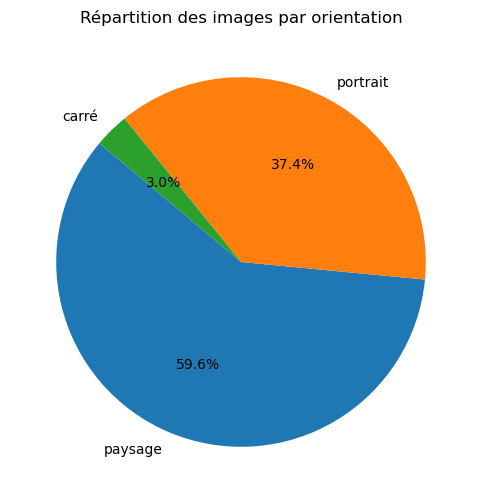

In [27]:
def visualize_orientation_distribution(annotations):
    orientations = [ann.get("orientation", "Inconnue") for ann in annotations]
    orientation_counts = Counter(orientations)
    labels = list(orientation_counts.keys())
    counts = list(orientation_counts.values())
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title("Répartition des images par orientation")
    plt.show()

visualize_orientation_distribution(annotations)


##### Interprétation 
* Ce graphique circulaire indique la distribution des images selon leur orientation (par exemple, "paysage", "portrait", "carré").

On peut ainsi identifier l'orientation majoritaire de paysage avec une pourcentage de 59.6 % , ce qui peut influencer la manière dont les images sont présentées ou recommandées.

#### Visualisation – Profil utilisateur

Profil utilisateur:
{
    "user_id": 1,
    "selected_images": [
        "images/image_28.jpg",
        "images/image_42.jpg",
        "images/image_78.jpg",
        "images/image_49.jpg",
        "images/image_8.jpg",
        "images/image_14.jpg",
        "images/image_55.jpg",
        "images/image_7.jpeg",
        "images/image_6.tif",
        "images/image_19.jpg"
    ],
    "preferred_orientation": "paysage",
    "preferred_size_category": "large",
    "preferred_color": "#6b7f9f",
    "favorite_tags": [
        "haute_resolution",
        "paysage",
        "portrait"
    ],
    "average_resolution": {
        "width": 3114,
        "height": 2984
    },
    "cluster": 0
}


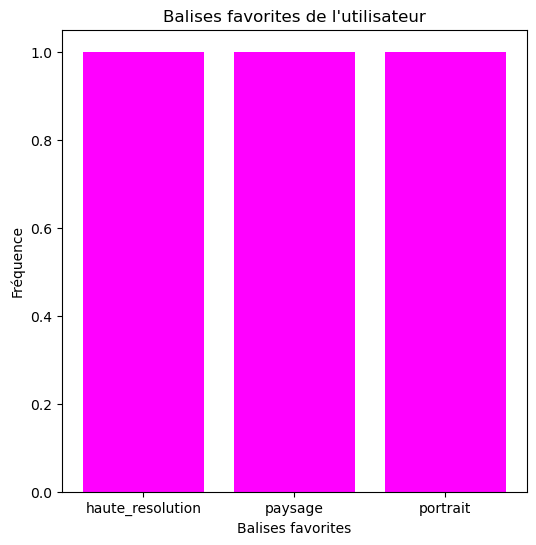

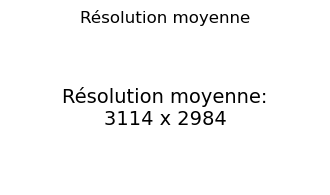

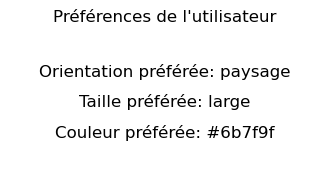

In [34]:
def visualize_user_profile(user_profiles, user_id):
    # Recherche du profil correspondant
    profile = None
    for up in user_profiles:
        if up.get("user_id") == user_id:
            profile = up
            break
    if profile is None:
        print(f"Utilisateur avec l'ID {user_id} non trouvé.")
        return

    # Affichage du profil dans la console
    print("Profil utilisateur:")
    print(json.dumps(profile, indent=4, ensure_ascii=False))

    # Visualisation des balises favorites
    favorite_tags = profile.get("favorite_tags", [])
    if favorite_tags:
        tag_counts = Counter(favorite_tags)
        labels = list(tag_counts.keys())
        counts = list(tag_counts.values())
        plt.figure(figsize=(6, 6))
        plt.bar(labels, counts, color='magenta')
        plt.xlabel("Balises favorites")
        plt.ylabel("Fréquence")
        plt.title("Balises favorites de l'utilisateur")
        plt.show()
    else:
        print("Aucune balise favorite à afficher pour cet utilisateur.")

    # Visualisation de la résolution moyenne
    avg_res = profile.get("average_resolution", {})
    avg_width = avg_res.get("width", 0)
    avg_height = avg_res.get("height", 0)
    plt.figure(figsize=(4, 2))
    plt.text(0.5, 0.5, f"Résolution moyenne:\n{avg_width} x {avg_height}", fontsize=14, ha='center', va='center')
    plt.axis('off')
    plt.title("Résolution moyenne")
    plt.show()

    # Affichage des préférences textuelles
    pref_orientation = profile.get("preferred_orientation", "Inconnue")
    pref_size = profile.get("preferred_size_category", "Inconnue")
    pref_color = profile.get("preferred_color", "#000000")
    plt.figure(figsize=(4, 2))
    plt.text(0.5, 0.7, f"Orientation préférée: {pref_orientation}", fontsize=12, ha='center')
    plt.text(0.5, 0.5, f"Taille préférée: {pref_size}", fontsize=12, ha='center')
    plt.text(0.5, 0.3, f"Couleur préférée: {pref_color}", fontsize=12, ha='center')
    plt.axis('off')
    plt.title("Préférences de l'utilisateur")
    plt.show()

# Charger les profils utilisateurs depuis "user_profiles.json"
with open("user_profiles.json", "r", encoding="utf-8") as f:
    user_profiles = json.load(f)

# Par exemple, visualiser le profil de l'utilisateur avec ID 1
visualize_user_profile(user_profiles, 1)


##### Interprétation du profil utilisateur :
* Cette visualisation présente le profil d'un utilisateur sélectionné (ici, l'utilisateur avec l'ID 1).

   * Balises favorites : Le graphique en barres montre la fréquence des tags favoris, révélant les thèmes les plus récurrents dans ses préférences.
   * Résolution moyenne : L'affichage textuel indique la résolution moyenne des images choisies par l'utilisateur, ce qui peut être utile pour évaluer  la qualité des images qu'il préfère.
   * Préférences textuelles : Les préférences en termes d'orientation, de catégorie de taille et de couleur donnent un aperçu global des goûts de l'utilisateur.

## Phase 5 :Système de recommandation
Dans cette étape, nous construisons un système de recommandation d'images basé sur le contenu. L'objectif est de proposer à chaque utilisateur des images correspondant le mieux à ses préférences. Pour cela, nous utilisons les informations extraites et annotées lors des phases précédentes (fichiers `annotations.json` et `user_profiles.json`).

##### Approche et Critères

Nous adoptons une approche de filtrage basé sur le contenu. Chaque image est caractérisée par plusieurs critères :
- **Orientation** : L'image est classée en "paysage", "portrait" ou "carré".
- **Catégorie de taille** : Définie en fonction de la largeur de l'image (par exemple, "thumbnail", "medium" ou "large").
- **Couleur dominante** : Extraite à l'aide d'un algorithme K-means lors de la phase d'annotation, stockée au format hexadécimal.
- **Tags** : Balises générées à partir des métadonnées (par exemple, "architecture", "historic", etc.).

Pour chaque utilisateur, un profil est construit (en phase 3) contenant ses préférences :
- `preferred_orientation`
- `preferred_size_category`
- `preferred_color`
- `favorite_tags`

Le système de recommandation compare ces préférences avec les caractéristiques de chaque image à l'aide d'une fonction de similarité qui combine les critères (avec des poids ajustables). Les images ayant le meilleur score de similarité sont proposées à l'utilisateur.

##### Stockage et Gestion des Profils

Les profils utilisateurs sont stockés dans un fichier JSON (`user_profiles.json`) et peuvent être mis à jour en fonction des nouvelles interactions de l'utilisateur (par exemple, en modifiant ses tags favoris, sa couleur ou son orientation préférée).

## Limites et Perspectives

- **Données d'interaction réelles** : Le profil utilisateur est ici construit à partir de sélections simulées, et non d'un historique d'interactions réelles.
- **Pondération fixe** : Les poids appliqués à chaque critère sont actuellement statiques et pourraient être optimisés par apprentissage.
- **Approche hybride** : L'intégration d'un filtrage collaboratif, en plus du filtrage basé sur le contenu, pourrait améliorer la pertinence des recommandations.

In [43]:

import os
import json
import math
from collections import Counter

# -----------------------------------------------------------
# Fonctions utilitaires
# -----------------------------------------------------------

def get_size_category(width):
    """
    Retourne une catégorie de taille en fonction de la largeur.
    - thumbnail : largeur < 500 pixels
    - medium    : 500 <= largeur < 1500 pixels
    - large     : largeur >= 1500 pixels
    """
    if width < 500:
        return "thumbnail"
    elif width < 1500:
        return "medium"
    else:
        return "large"

def hex_to_rgb(hex_color):
    """
    Convertit une couleur hexadécimale (ex : "#ff5733") en tuple de valeurs RGB.
    """
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

# -----------------------------------------------------------
# Calcul de similarité entre une image et le profil d'un utilisateur
# -----------------------------------------------------------

def compute_similarity(user_profile, image, 
                       weight_orientation=1.0,
                       weight_size=1.0,
                       weight_color=2.0,
                       weight_tags=1.0):
    """
    Calcule un score de similarité entre une image et le profil d'un utilisateur.
    Les critères utilisés sont :
      1. Orientation : +1 si l'orientation de l'image correspond à celle du profil.
      2. Taille : comparaison de la catégorie de taille (basée sur la largeur).
      3. Couleur : on compare la couleur préférée de l'utilisateur avec les couleurs dominantes
         de l'image à l'aide de la distance euclidienne dans l'espace RGB (normalisée).
      4. Tags : proportion de tags en commun entre l'image et les tags favoris de l'utilisateur.
      
    Chaque critère est pondéré par un poids (modifiable selon l'importance souhaitée).
    """
    score = 0.0

    # 1. Orientation
    if image.get("orientation") == user_profile.get("preferred_orientation"):
        score += weight_orientation

    # 2. Taille (catégorie)
    image_width = image.get("taille", {}).get("largeur")
    if image_width:
        image_size_cat = get_size_category(image_width)
        if image_size_cat == user_profile.get("preferred_size_category"):
            score += weight_size

    # 3. Couleur
    user_color_hex = user_profile.get("preferred_color")
    if user_color_hex and "couleurs_dominantes" in image:
        user_rgb = hex_to_rgb(user_color_hex)
        # Calculer la distance minimale entre la couleur préférée et l'une des couleurs dominantes de l'image
        min_distance = None
        for col_hex in image["couleurs_dominantes"]:
            image_rgb = hex_to_rgb(col_hex)
            distance = math.sqrt(sum((u - i) ** 2 for u, i in zip(user_rgb, image_rgb)))
            if min_distance is None or distance < min_distance:
                min_distance = distance
        max_distance = math.sqrt(3 * (255 ** 2))  # distance maximale dans l'espace RGB
        if min_distance is not None:
            color_score = (max_distance - min_distance) / max_distance  # plus la distance est faible, meilleur est le score
            score += weight_color * color_score

    # 4. Tags
    user_tags = set(user_profile.get("favorite_tags", []))
    image_tags = set(image.get("tags", []))
    if user_tags and image_tags:
        common_tags = user_tags.intersection(image_tags)
        # Normalisation : rapport du nombre de tags communs sur le nombre total de tags favoris
        tag_score = len(common_tags) / float(len(user_tags))
        score += weight_tags * tag_score

    return score

# -----------------------------------------------------------
# Fonctions de gestion et stockage du profil utilisateur
# -----------------------------------------------------------

def update_user_preferences(user_id, new_preferences, user_profiles):
    """
    Met à jour les préférences du profil utilisateur identifié par user_id.
    new_preferences est un dictionnaire contenant les champs à mettre à jour.
    """
    for profile in user_profiles:
        if profile.get("user_id") == user_id:
            profile.update(new_preferences)
            return profile
    return None

def save_user_profiles(user_profiles, filename="user_profiles.json"):
    """Sauvegarde les profils utilisateurs dans un fichier JSON."""
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(user_profiles, f, ensure_ascii=False, indent=4)

def load_data(annotations_file="annotations.json", user_profiles_file="user_profiles.json"):
    """
    Charge les annotations (images et métadonnées) et les profils utilisateurs depuis des fichiers JSON.
    """
    if not os.path.exists(annotations_file):
        print(f"Le fichier {annotations_file} n'existe pas.")
        return None, None
    if not os.path.exists(user_profiles_file):
        print(f"Le fichier {user_profiles_file} n'existe pas.")
        return None, None
    with open(annotations_file, "r", encoding="utf-8") as f:
        annotations = json.load(f)
    with open(user_profiles_file, "r", encoding="utf-8") as f:
        user_profiles = json.load(f)
    return annotations, user_profiles

# -----------------------------------------------------------
# Algorithme de recommandation
# -----------------------------------------------------------

def recommend_images_for_user(user_id, annotations, user_profiles, top_n=10):
    """
    Pour un utilisateur donné (user_id), calcule un score de similarité pour chaque image,
    puis renvoie les top_n images ayant le meilleur score.
    """
    # Recherche du profil utilisateur
    user_profile = None
    for profile in user_profiles:
        if profile.get("user_id") == user_id:
            user_profile = profile
            break
    if user_profile is None:
        print(f"Profil utilisateur avec l'ID {user_id} non trouvé.")
        return []

    scored_images = []
    for image in annotations:
        score = compute_similarity(user_profile, image)
        scored_images.append((image, score))
    
    # Trier les images par score décroissant
    scored_images.sort(key=lambda x: x[1], reverse=True)
    return scored_images[:top_n]

# -----------------------------------------------------------
# Exemple d'utilisation
# -----------------------------------------------------------

def main():
    # Charger les annotations et les profils utilisateurs
    annotations, user_profiles = load_data()
    if annotations is None or user_profiles is None:
        return

    # --- Gestion et mise à jour des préférences utilisateur ---
    # Par exemple, mettons à jour le profil de l'utilisateur 1
    user_id = 1
    # On simule une mise à jour des préférences de l'utilisateur (par exemple, après une nouvelle interaction)
    new_preferences = {
        "favorite_tags": ["architecture", "landmark", "historic"],  # nouveaux tags favoris
        "preferred_color": "#ff5733",      # nouvelle couleur préférée
        "preferred_orientation": "paysage", # orientation préférée
        "preferred_size_category": "medium" # catégorie de taille préférée
    }
    updated_profile = update_user_preferences(user_id, new_preferences, user_profiles)
    if updated_profile:
        print(f"Profil utilisateur {user_id} mis à jour :")
        print(json.dumps(updated_profile, indent=4, ensure_ascii=False))
        save_user_profiles(user_profiles)
    else:
        print(f"Profil utilisateur {user_id} introuvable. Impossible de mettre à jour les préférences.")

    # --- Recommandation d'images ---
    recommendations = recommend_images_for_user(user_id, annotations, user_profiles, top_n=10)
    print(f"\nRecommandations pour l'utilisateur {user_id} :")
    for idx, (image, score) in enumerate(recommendations, start=1):
        print(f"{idx}. {image.get('nom_fichier')} - Score de similarité : {score:.3f}")

if __name__ == "__main__":
    main()


Profil utilisateur 1 mis à jour :
{
    "user_id": 1,
    "selected_images": [
        "images/image_28.jpg",
        "images/image_42.jpg",
        "images/image_78.jpg",
        "images/image_49.jpg",
        "images/image_8.jpg",
        "images/image_14.jpg",
        "images/image_55.jpg",
        "images/image_7.jpeg",
        "images/image_6.tif",
        "images/image_19.jpg"
    ],
    "preferred_orientation": "paysage",
    "preferred_size_category": "medium",
    "preferred_color": "#ff5733",
    "favorite_tags": [
        "architecture",
        "landmark",
        "historic"
    ],
    "average_resolution": {
        "width": 3114,
        "height": 2984
    },
    "cluster": 0
}

Recommandations pour l'utilisateur 1 :
1. images/image_3.jpg - Score de similarité : 3.454
2. images/image_34.jpeg - Score de similarité : 3.300
3. images/image_8.jpg - Score de similarité : 3.284
4. images/image_39.jpg - Score de similarité : 2.883
5. images/image_15.jpg - Score de similarité : 2